# Esperimento loss function: FocusedDiceLoss

Nei notebook precedenti abbiamo visto come sia la *Dice* che la *Focal* loss presentino, almeno in teoria, delle aspetti metodologici più opportuni per il nostro problema rispetto ad altre loss function (e.g. BCE).

Come task per l'esame di questo corso, la sfida è quella di sperimentare con una nuova loss ottenuta come combinazione delle due menzionate sopra. In particolare:

 - deve combinare le due quantità additivamente
 - la componente *Dice* deve essere opportunamente pesata da un fattore parametrizzabile *alpha*:
 
 $$FocusedDiceLoss = FocalLoss(y_{\text{pred}}, y) + \alpha \cdot DiceLoss(y_{\text{pred}}, y)$$
 
 

# Soluzione

## Focused Dice loss

In [1]:
from fastai.vision.all import *
from fastai.losses import FocalLossFlat


class FocusedDiceLoss:
    "Dice and Focal combined"

    def __init__(self, axis=1, alpha=1., smooth=1., gamma=2.):
        self.name = 'FocusedDiceLoss'
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis, gamma=gamma)
        self.dice_loss = DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x): return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

## Configurazione esperimento

Per prima cosa, è utile raggruppare tutti gli iperparametri che influenzano l'addestramento della rete neurale in un unico punto d'accesso, così da rendere più semplici eventuali modifiche.

Allo stesso tempo, è buona prassi tener traccia della configurazione di ogni esperimento per ricostruire quali impostazioni hanno portato a ciascun risultato. Nel nostro caso, il progetto è strutturato con due cartelle di logging:

- *log_path*: vengono registrate tutte le metriche di training
- *model_path*: contiene il modello pre-addestrato migliore prodotto da ciascun esperimento

In [2]:
import sys

sys.path.insert(0, str(Path.cwd().parent))

from utils import write_config, load_config

# data and augmentation params
BS = 32
CROP_SIZE = 512
RESIZE = 224
MAX_LIGHT = 0.1
ZOOM_DELTA = 0.9  # min_zoom = 1 - ZOOM_DELTA; max_zoom = 1 + ZOOM_DELTA
MAX_ROTATION_ANGLE = 15.0

# model params
N_IN, N_OUT = 16, 2

# optimizer params
# W_CELL, W_BKGD = 1, 1
LOSS_FUNC, LOSS_NAME = FocusedDiceLoss(axis=1, alpha=1.5, gamma=2.0, smooth=1e-06), 'Combined'
LR = None
OPT, OPT_NAME = partial(Adam, lr=LR), 'Adam'
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'dice', 0, 20 # early stopping
FACTOR, PATIENCE_LR = 1.2, 4 # scheduling learning rate


hyperparameter_defaults = dict(
    bs=BS,
    crop_size=CROP_SIZE,
    resize=RESIZE,
    batch_size=BS,
    angle=MAX_ROTATION_ANGLE,
    zoom_delta=ZOOM_DELTA,
    max_light=MAX_LIGHT,
    # model
    n_in=N_IN, n_out=N_OUT,
    # optimizer
    loss_func=LOSS_FUNC, loss_name=LOSS_NAME,
    lr=LR,
    opt=OPT, opt_name=OPT_NAME,
    monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES},
    lr_monit_dict={'factor': FACTOR, 'patience': PATIENCE_LR},
)

cfg = namedtuple('Config', hyperparameter_defaults.keys())(
    **hyperparameter_defaults)

EXP_NAME = f'{LOSS_NAME}'
log_path = Path().cwd().parent / 'logs' / EXP_NAME  
log_path.mkdir(exist_ok=True, parents=True)

model_path = f'{log_path.parent.parent}/models/{EXP_NAME}'

# save config
write_config(hyperparameter_defaults, log_path / "cfg.pkl")
# loaded_cfg = load_config(log_path / "cfg.pkl")

##  Dataloader


/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


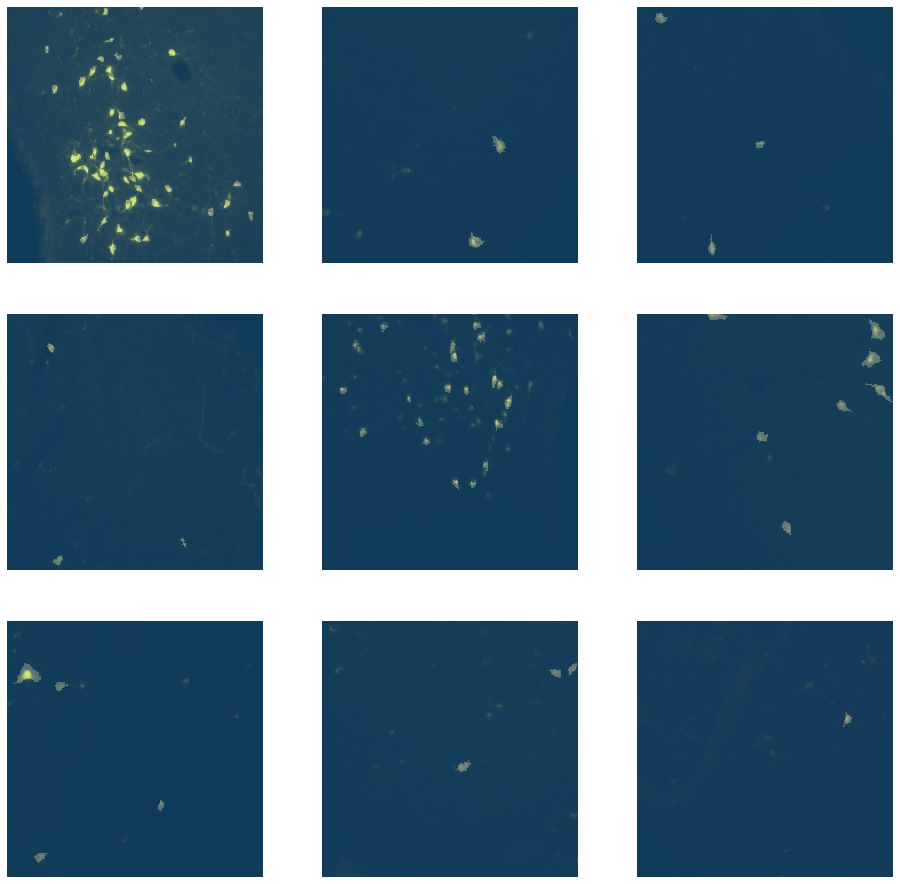

In [3]:
data_path = Path('../fluocells_data/all_images')

# read train/valid/test split dataframe
split_df = pd.read_csv(data_path.parent / 'split_df.csv')
trainval_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='train' or split=='valid'").filename]

def label_func(p):
    return Path(str(p).replace('images', 'masks'))

def is_valid(p):
    return split_df.loc[split_df.filename == p.name, 'split'].values[0] == 'valid'

# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
    RandomCrop(512),
    *aug_transforms(
        size=224, # resize
        max_lighting=0.1, p_lighting=0.5, # variazione luminosità
        min_zoom=0.9, max_zoom=1.1, # zoom
        max_warp=0, # distorsione
        max_rotate=15.0 # rotazione
    )
]


# splitter
splitter = FuncSplitter(lambda p: is_valid(p))

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    data_path, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    batch_tfms=tfms,
    device='cuda'
)

dls.show_batch(max_n=9, figsize=(16,16))

## Learner

In [4]:
from blocks import cResUnet

model = cResUnet(cfg.n_in, cfg.n_out)

CBS = [
#     ReduceLROnPlateau(monitor=MONIT_SCORE,
#                       patience=PATIENCE_LR, factor=FACTOR),
#     EarlyStoppingCallback(monitor=MONIT_SCORE,
#                           min_delta=MIN_DELTA, patience=PATIENCE_ES),
#     SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
#                       every_epoch=False, at_end=False, with_opt=False, reset_on_fit=False),
    CSVLogger
]


learn = Learner(dls, model=model, loss_func=cfg.loss_func,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                cbs=CBS,
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/logs/Combined
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/models/Combined


cResUnet (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 1 x 224 x 224  
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     32 x 16 x 224 x 224 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     32 x 16 x 112 x 112 
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                  

SuggestedLRs(valley=0.0030199517495930195)

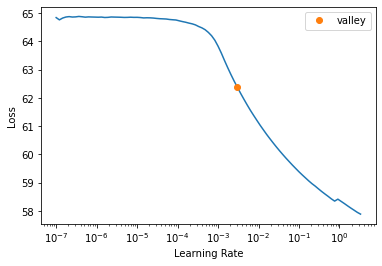

In [5]:
res = learn.lr_find()
res

### Addestramento 

In [6]:
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'dice', 0.005, 20
cfg._replace(monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES})
cfg._replace(lr=res.valley)
cfg._replace(opt=partial(Adam, lr=cfg.lr))
write_config(hyperparameter_defaults, log_path / "cfg.pkl")

CBS = [
    SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
                      every_epoch=False, at_end=False, with_opt=True, reset_on_fit=False),
    CSVLogger
]

learn.fit_one_cycle(n_epoch=150, lr_max=cfg.lr, cbs=CBS)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,64.697357,54.782402,0.012106,0.006090,1.000000,00:09
1,64.538605,54.740681,0.012106,0.006090,1.000000,00:09
2,64.386917,54.677811,0.012106,0.006090,1.000000,00:10
3,64.227882,54.576981,0.012106,0.006090,1.000000,00:10
4,64.039261,54.421558,0.012106,0.006090,1.000000,00:10
5,63.815880,54.252560,0.012834,0.006459,0.969060,00:10
6,63.513355,54.166378,0.013598,0.006845,0.959004,00:13
7,63.061901,54.131386,0.016150,0.008141,0.891341,00:11
8,62.380840,53.758003,0.030919,0.015702,0.532770,00:10
9,61.468868,52.523281,0.036934,0.018815,0.021231,00:14


Better model found at epoch 0 with dice value: 0.012106146292958796.
Better model found at epoch 8 with dice value: 0.030919304333878912.
Better model found at epoch 9 with dice value: 0.036934139565288446.
Better model found at epoch 34 with dice value: 0.10480985018499424.
Better model found at epoch 38 with dice value: 0.4949583516001754.
Better model found at epoch 49 with dice value: 0.5285708467397059.
Better model found at epoch 53 with dice value: 0.5412461422971057.
Better model found at epoch 57 with dice value: 0.6014126510751844.
Better model found at epoch 70 with dice value: 0.6406007537131456.
Better model found at epoch 81 with dice value: 0.651612365636197.
Better model found at epoch 98 with dice value: 0.6584790276332817.
Better model found at epoch 105 with dice value: 0.6693220658287806.
Better model found at epoch 115 with dice value: 0.6755419911597559.


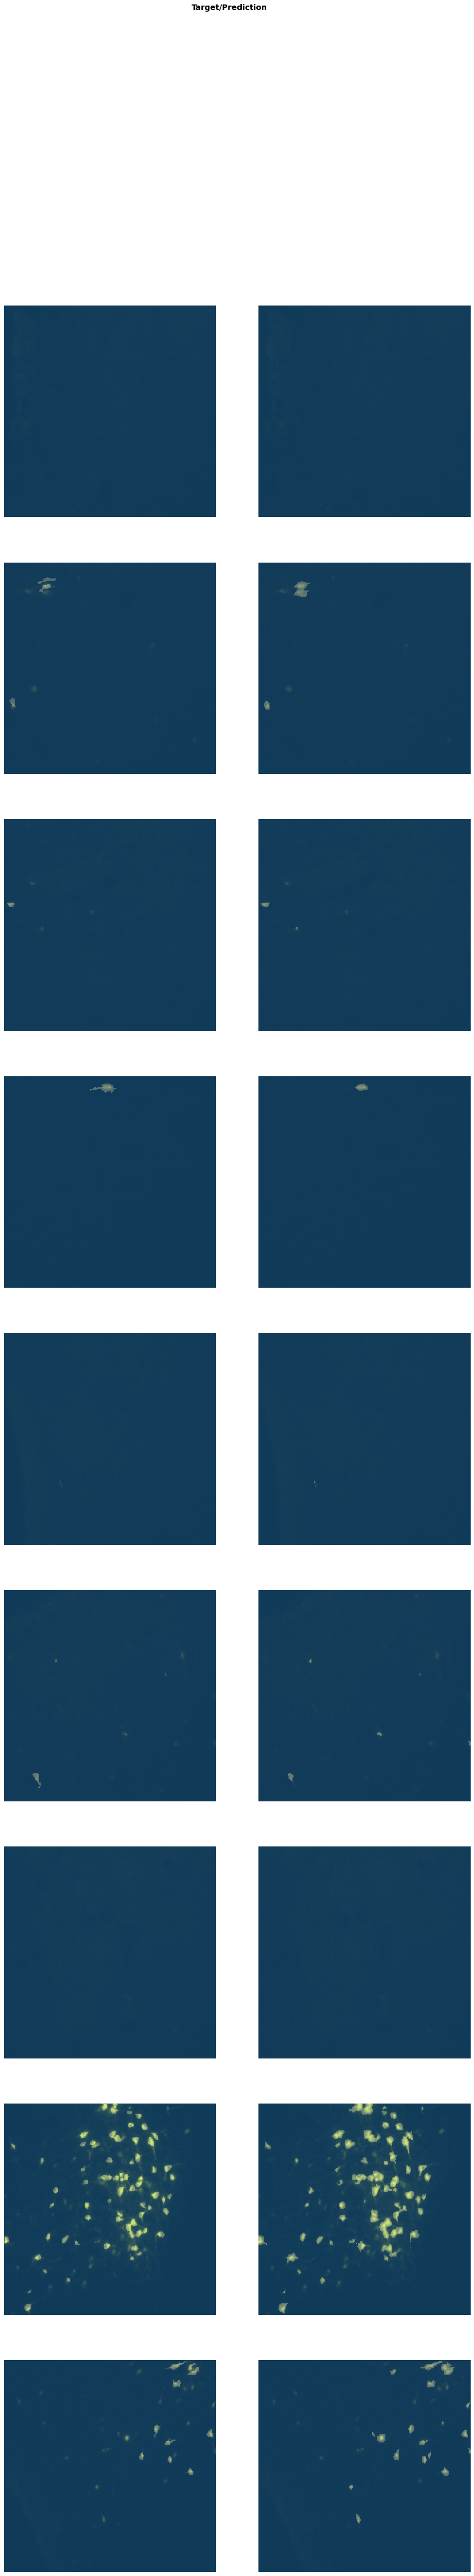

In [7]:
learn.show_results(figsize=(15, 75))